In [1]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

#import functions from my .py files
from acquire import get_zillow_data
from prep import remove_outliers,remove_outlier, split_continuous, clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale
from explore import plot_variable_pairs, plot_pairplot, plot_categorical_and_continuous_vars, correlation_exploration
from feature_engineering import select_kbest

In [2]:
#acquire our Zillow data from CodeUp server, and turn into .csv
df = get_zillow_data()

In [3]:
df['age'] = 2017-df['yearbuilt']

In [4]:
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,age
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04,43.0
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21,94.0
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23,47.0
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28,37.0
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30,106.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38622 entries, 0 to 38621
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      38622 non-null  int64  
 1   id                            38622 non-null  int64  
 2   airconditioningtypeid         12224 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38622 non-null  float64
 6   bedroomcnt                    38622 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         23706 non-null  float64
 9   calculatedbathnbr             38463 non-null  float64
 10  decktypeid                    333 non-null    float64
 11  finishedfloor1squarefeet      3339 non-null   float64
 12  calculatedfinishedsquarefeet  38509 non-null  float64
 13  f

In [6]:
def clean_zillow(df):
    '''
    this function takes in an unclean zillow df and does the following:
    1.) keeps only columns we need for the project
    2.) drops nulls
    3.) renames columns
    '''
    #select features for df
    features = ['parcelid', 'calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'yearbuilt','fips']
    df = df[features]
    df = df.drop_duplicates(subset=['parcelid'])
    
    #rename columns for easier use
    df = df.rename(columns={
                            'parcelid': 'parcel_id',
                            'calculatedfinishedsquarefeet': 'sqft',
                            'bathroomcnt': 'baths',
                            'bedroomcnt': 'beds',
                            'taxvaluedollarcnt':'tax_value'
        
    })
    
    #set index
    df = df.set_index('parcel_id')
    #drop nulls
    df = df.dropna(subset=['sqft','tax_value'])
    
    return df

In [7]:
df = clean_zillow(df)

In [8]:
df.head()

,sqft,baths,beds,tax_value,yearbuilt,fips
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,1974.0,6059.0
11721753,1316.0,2.0,3.0,205123.0,1923.0,6037.0
11289917,1458.0,2.0,3.0,136104.0,1970.0,6037.0
11637029,1766.0,2.0,3.0,810694.0,1980.0,6037.0
11705026,1421.0,1.0,2.0,35606.0,1911.0,6037.0


In [9]:
df.dropna(subset=['yearbuilt'])

,sqft,baths,beds,tax_value,yearbuilt,fips
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,1974.0,6059.0
11721753,1316.0,2.0,3.0,205123.0,1923.0,6037.0
11289917,1458.0,2.0,3.0,136104.0,1970.0,6037.0
11637029,1766.0,2.0,3.0,810694.0,1980.0,6037.0
11705026,1421.0,1.0,2.0,35606.0,1911.0,6037.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,2002.0,6059.0
12019061,769.0,2.0,1.0,492395.0,1964.0,6037.0
11570288,1212.0,2.0,2.0,600608.0,1969.0,6037.0


In [10]:
df['age']=2017-df['yearbuilt']

In [11]:
df

,sqft,baths,beds,tax_value,yearbuilt,fips,age
parcel_id,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,1974.0,6059.0,43.0
11721753,1316.0,2.0,3.0,205123.0,1923.0,6037.0,94.0
11289917,1458.0,2.0,3.0,136104.0,1970.0,6037.0,47.0
11637029,1766.0,2.0,3.0,810694.0,1980.0,6037.0,37.0
11705026,1421.0,1.0,2.0,35606.0,1911.0,6037.0,106.0
...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,2002.0,6059.0,15.0
12019061,769.0,2.0,1.0,492395.0,1964.0,6037.0,53.0
11570288,1212.0,2.0,2.0,600608.0,1969.0,6037.0,48.0


In [12]:
df = df.drop(columns=['yearbuilt'])

In [13]:
df

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,43.0
11721753,1316.0,2.0,3.0,205123.0,6037.0,94.0
11289917,1458.0,2.0,3.0,136104.0,6037.0,47.0
11637029,1766.0,2.0,3.0,810694.0,6037.0,37.0
11705026,1421.0,1.0,2.0,35606.0,6037.0,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,15.0
12019061,769.0,2.0,1.0,492395.0,6037.0,53.0
11570288,1212.0,2.0,2.0,600608.0,6037.0,48.0


In [14]:
df.fips.unique()

array([6059., 6037., 6111.])

In [15]:
df.fips.value_counts()

6037.0    23998
6059.0    11068
6111.0     3409
Name: fips, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38475 entries, 14634203 to 10713993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       38475 non-null  float64
 1   baths      38475 non-null  float64
 2   beds       38475 non-null  float64
 3   tax_value  38475 non-null  float64
 4   fips       38475 non-null  float64
 5   age        38447 non-null  float64
dtypes: float64(6)
memory usage: 2.1 MB


In [17]:
df['fips'].replace({'6037.0': 'Los Angeles County', '6059.0': 'Orange County', '6111.0': 'Ventura County'}, inplace=True)

In [18]:
df

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,43.0
11721753,1316.0,2.0,3.0,205123.0,6037.0,94.0
11289917,1458.0,2.0,3.0,136104.0,6037.0,47.0
11637029,1766.0,2.0,3.0,810694.0,6037.0,37.0
11705026,1421.0,1.0,2.0,35606.0,6037.0,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,15.0
12019061,769.0,2.0,1.0,492395.0,6037.0,53.0
11570288,1212.0,2.0,2.0,600608.0,6037.0,48.0


In [19]:
df.beds = df.beds.astype('int64')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38475 entries, 14634203 to 10713993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       38475 non-null  float64
 1   baths      38475 non-null  float64
 2   beds       38475 non-null  int64  
 3   tax_value  38475 non-null  float64
 4   fips       38475 non-null  float64
 5   age        38447 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.1 MB


In [21]:
df.fips = df.fips.astype('int64')

In [22]:
df.fips

parcel_id
14634203    6059
11721753    6037
11289917    6037
11637029    6037
11705026    6037
            ... 
14453399    6059
12019061    6037
11570288    6037
11128688    6037
10713993    6037
Name: fips, Length: 38475, dtype: int64

In [23]:
df.dropna(subset=['age'])

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3,289445.0,6059,43.0
11721753,1316.0,2.0,3,205123.0,6037,94.0
11289917,1458.0,2.0,3,136104.0,6037,47.0
11637029,1766.0,2.0,3,810694.0,6037,37.0
11705026,1421.0,1.0,2,35606.0,6037,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5,852813.0,6059,15.0
12019061,769.0,2.0,1,492395.0,6037,53.0
11570288,1212.0,2.0,2,600608.0,6037,48.0


In [24]:
df.info()
df = df.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38475 entries, 14634203 to 10713993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       38475 non-null  float64
 1   baths      38475 non-null  float64
 2   beds       38475 non-null  int64  
 3   tax_value  38475 non-null  float64
 4   fips       38475 non-null  int64  
 5   age        38447 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 2.1 MB


In [25]:
df

,sqft,baths,beds,tax_value,fips,age
parcel_id,,,,,,
14634203,1125.0,2.0,3,289445.0,6059,43.0
11721753,1316.0,2.0,3,205123.0,6037,94.0
11289917,1458.0,2.0,3,136104.0,6037,47.0
11637029,1766.0,2.0,3,810694.0,6037,37.0
11705026,1421.0,1.0,2,35606.0,6037,106.0
...,...,...,...,...,...,...
14453399,3015.0,3.0,5,852813.0,6059,15.0
12019061,769.0,2.0,1,492395.0,6037,53.0
11570288,1212.0,2.0,2,600608.0,6037,48.0


In [26]:
target = 'tax_value'

In [27]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)

In [28]:
train.shape, validate.shape, test.shape

((21546, 6), (9234, 6), (7695, 6))

In [29]:
obj_cols = get_object_cols(df)

In [30]:
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [31]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

In [32]:
X_train_scaled

,sqft,baths,beds,fips,age
12094957,0.151838,0.272727,0.4,0.000000,0.303704
12032697,0.022934,0.090909,0.1,0.000000,0.622222
11135945,0.186710,0.454545,0.5,0.000000,0.103704
17062341,0.040223,0.181818,0.2,1.000000,0.237037
10722461,0.053690,0.181818,0.3,0.000000,0.451852
...,...,...,...,...,...
12050831,0.065922,0.181818,0.2,0.000000,0.681481
14717936,0.062570,0.227273,0.3,0.297297,0.155556
11451314,0.053925,0.181818,0.3,0.000000,0.466667
17133084,0.073861,0.181818,0.4,1.000000,0.400000


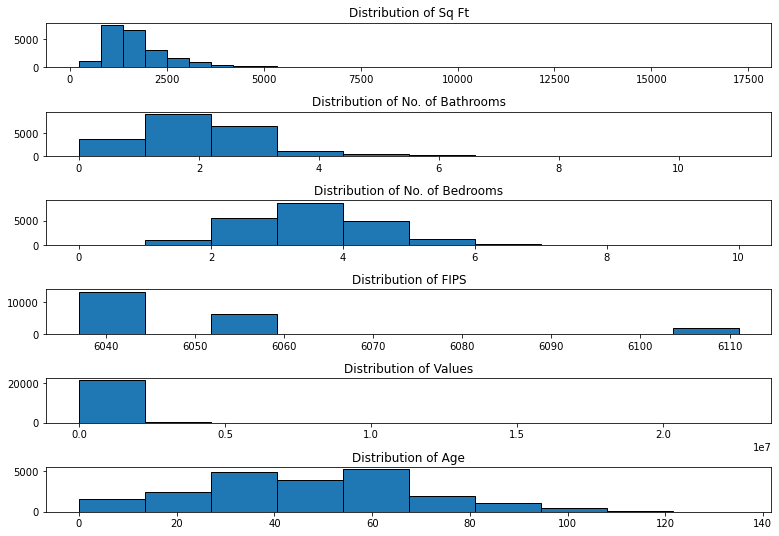

In [33]:
plt.figure(figsize=(13,9))
plt.subplot(6,1,1, title='Distribution of Sq Ft')
plt.hist(data=train, x='sqft', bins = 30,ec='black')

plt.subplot(6,1,2, title='Distribution of No. of Bathrooms')
plt.hist(data=train, x='baths', ec='black')

plt.subplot(6,1,3, title='Distribution of No. of Bedrooms')
plt.hist(data=train, x='beds',ec='black')

plt.subplot(6,1,4, title='Distribution of FIPS')
plt.hist(data=train, x='fips',ec='black')

plt.subplot(6,1,5, title='Distribution of Values')
plt.hist(data=train, x='tax_value',ec='black')

plt.subplot(6,1,6, title='Distribution of Age')
plt.hist(data=train, x='age',ec='black')

plt.subplots_adjust(hspace=1)
plt.show()

In [34]:
cols = ['sqft', 'baths','beds','fips','age','tax_value']

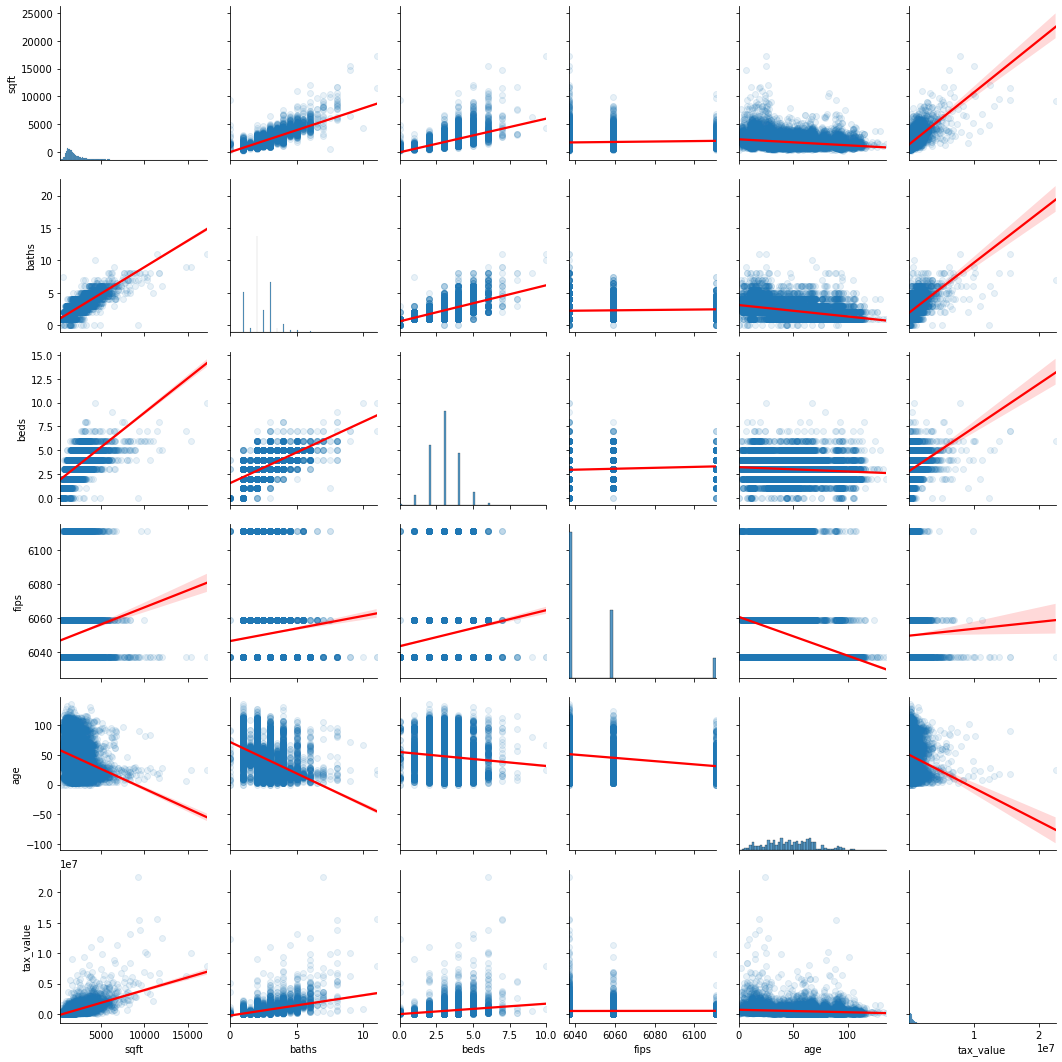

In [35]:
plot_variable_pairs(train, cols)

In [36]:
def get_heatmap(train):
    plt.figure(figsize=(8,12))
    heatmap = sns.heatmap(df.corr()[['tax_value']].sort_values(by='tax_value', ascending=False), vmin=-.5, vmax=.5, annot=True)
    heatmap.set_title('Feautures Correlating with Value')
    
    return heatmap

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

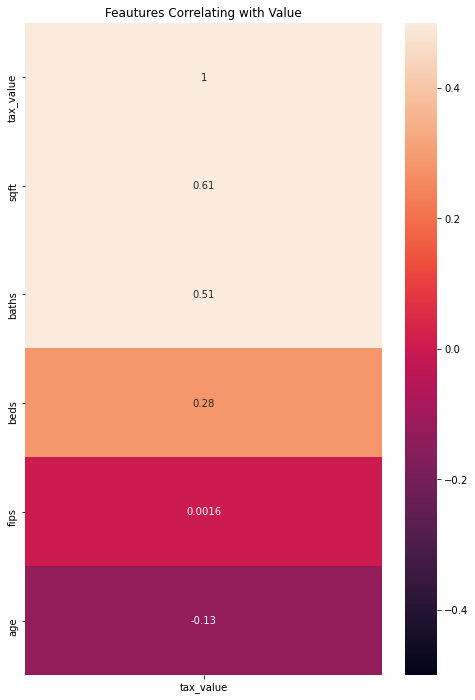

In [37]:
get_heatmap(train)

In [38]:
select_kbest(X_train_scaled, y_train,5)

['sqft', 'baths', 'beds', 'fips', 'age']

In [39]:
#tells us which features we should keep
import statsmodels.api as sm
cols = list(X_train_scaled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['sqft', 'baths', 'beds', 'fips', 'age']


In [40]:
#using RFE
number_of_features_list=np.arange(1,7)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 5
Score with 5 features: 0.370154


In [41]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 5)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sqft', 'baths', 'beds', 'fips', 'age'], dtype='object')


In [42]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 5)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sqft', 'baths', 'beds', 'fips', 'age'], dtype='object')


In [43]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('BASELINE')
print('--------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('--------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

BASELINE
--------------------
RMSE using Mean
Train/In-Sample:  621167.38 
Validate/Out-of-Sample:  652064.88
--------------------
RMSE using Median
Train/In-Sample:  634577.05 
Validate/Out-of-Sample:  668821.56


In [44]:
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The r^2 score for baseline is {r2_baseline}')

The r^2 score for baseline is -0.000979769002724673


In [45]:
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled,y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  470018.63462614303 
Validation/Out-of-Sample:  511826.7636719257


In [46]:
r2_score_lm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)
r2_score_lm

0.38327767922848854

In [47]:
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled,y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using Lasso+Lars
Training/In-Sample:  470018.875386389 
Validation/Out-of-Sample:  511834.4327601418


In [48]:
r2_score_lars = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)
r2_score_lars

0.3832591974543694

In [49]:
#create model object
glm = TweedieRegressor(power =0, alpha=0.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled,y_train.tax_value)

#predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using TweedieRegressor
Training/In-Sample:  470018.63462614303 
Validation/Out-of-Sample:  511826.7634436523


In [50]:
r2_score_glm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)
r2_score_glm

0.3832776797786016

In [51]:
#making polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

#transform X_validate_scaled, and X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [52]:
#okay let's do linear regression again
lm2 = LinearRegression(normalize=True)

#fit the model using scaled X_train, once again specify y_train column
lm2.fit(X_train_degree2, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

#evaluate rmse for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

#predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

#evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  448686.4897916745 
Validation/Out-of-Sample:  503707.3656057897


In [53]:
r2_score_lm2 = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm2)
r2_score_lm2

0.40268931084983806

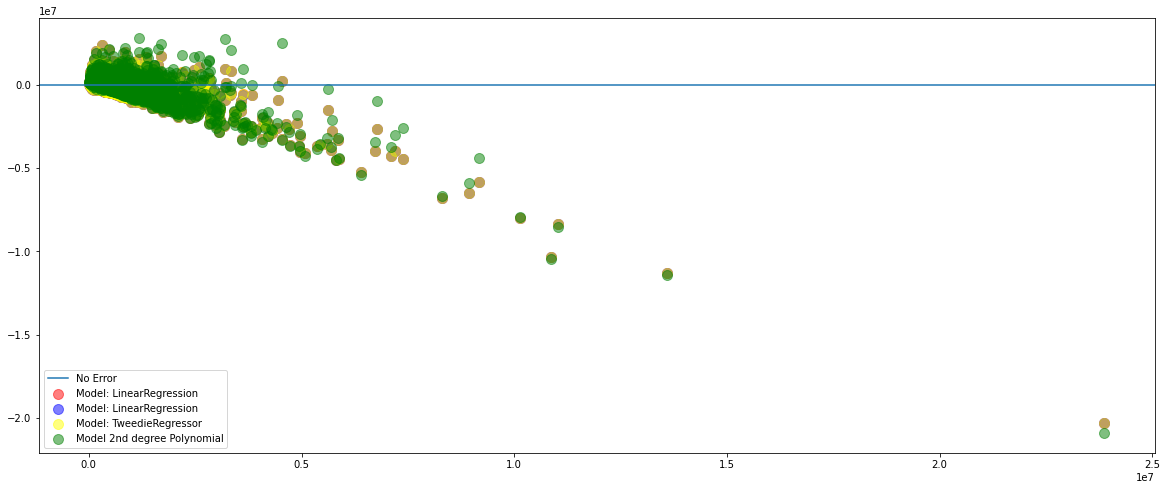

In [54]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars-y_validate.tax_value, 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()

<AxesSubplot:xlabel='tax_value', ylabel='tax_value_pred_lm2'>

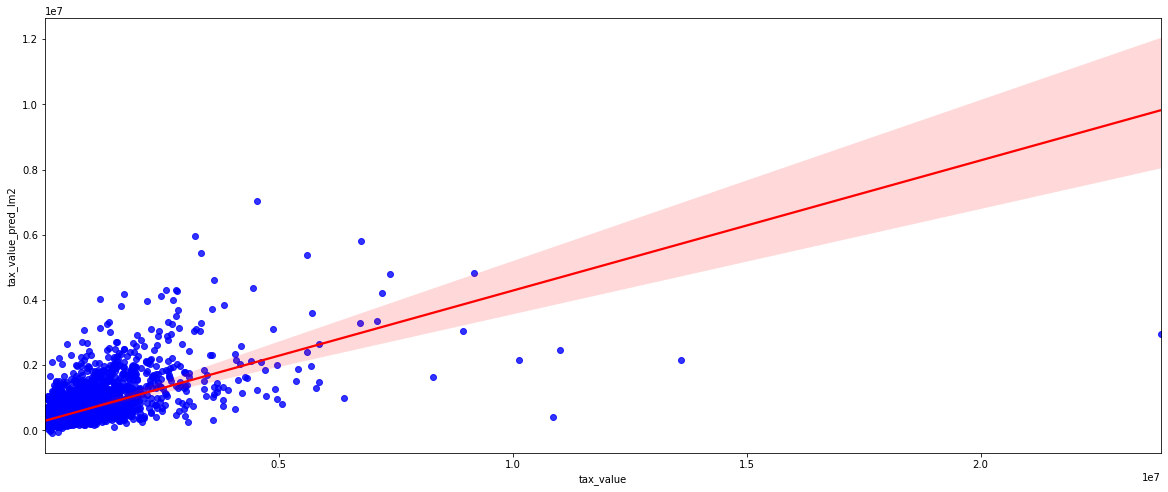

In [55]:
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.tax_value_pred_lm2, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})

### Test

In [56]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2)**(1/2)

print("RMSE for OLS Model using LinearRegression (2 degrees)\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression (2 degrees)
Out-of-Sample Performance:  476654.69512114284


In [57]:
r2_test_score_lm2 = r2_score(y_test.tax_value, y_test.tax_value_pred_lm2)
print(f'LinearRegression(2 degrees) has an R^2 value of {r2_test_score_lm2}')

LinearRegression(2 degrees) has an R^2 value of 0.40384902016210245


### Tax Rates for Each County